# Sentiment Analysis on IMDB Reviews using LSTM

Steps

1. Load the dataset (IMDB Movie Review)
2. Clean Dataset
3. Encode Sentiments
4. Split Dataset
5. Tokenize and Pad/Truncate Reviews
6. Build Architecture/Model
7. Train and Test


In [2]:
# Import all the libraries needed

import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pickle
import tensorflow as tf

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
# Load and clean data
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english')) # Stop Word is a commonly used words in a sentence, usually a search engine is programmed to ignore this words (i.e. "the", "a", "an", "of", etc.) Declaring the english stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

In [5]:
data = pd.read_csv('dataset/merge_data.csv', header=None, names=['text', 'label'])
data['cleaned_text'] = data['text'].apply(clean_text)

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_text'],
    data['label'],
    test_size=0.2,
    random_state=42
)

In [7]:
# Step 2 - Prepare Text Data for LSTM
# Tokenize text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [8]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [9]:
# Pad sequences to same length
max_len = 100  # Maximum length of sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

In [10]:
# Step 3 - Build LSTM Model
embedding_dim = 128
lstm_units = 64

# Enhanced model architecture
model = Sequential([
    Embedding(input_dim=10000,  # Increased vocabulary size
              output_dim=300,  # Increased embedding dimension
              input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True,  # First bidirectional layer
                     dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(64,  # Second bidirectional layer
                     dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),  # Additional dense layer
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
# Use learning rate scheduling
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
# Add learning rate reducer
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0001)

# Add model checkpoint
checkpoint = ModelCheckpoint('best_model.h5',
                            monitor='val_accuracy',
                            save_best_only=True,
                            mode='max')

In [20]:
# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Train with callbacks
history = model.fit(
    X_train_pad,
    y_train,
    validation_split=0.1,
    epochs=5,  # Increased epochs
    batch_size=256,  # Try larger batch size
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8959 - loss: 0.2835

141/141 ━━━━━━━━━━━━━━━━━━━━ 473s 3s/step - accuracy: 0.8959 - loss: 0.2835 - val_accuracy: 0.8690 - val_loss: 0.3228 - learning_rate: 2.0000e-04
Epoch 2/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 495s 3s/step - accuracy: 0.9030 - loss: 0.2593 - val_accuracy: 0.8670 - val_loss: 0.3288 - learning_rate: 2.0000e-04
Epoch 3/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 463s 3s/step - accuracy: 0.9136 - loss: 0.2405 - val_accuracy: 0.8655 - val_loss: 0.3316 - learning_rate: 2.0000e-04
Epoch 4/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.9210 - loss: 0.2211 - val_accuracy: 0.8675 - val_loss: 0.3393 - learning_rate: 1.0000e-04


In [21]:
# Step 4 - Evaluate Model
# Predict probabilities
y_pred_proba = model.predict(X_test_pad)

# Convert to binary predictions (0 or 1)
y_pred = (y_pred_proba > 0.5).astype(int)

313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 149ms/step


In [22]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"LSTM Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

LSTM Model Evaluation:
Accuracy: 0.8672
Precision: 0.8761
Recall: 0.8546
F1-score: 0.8652


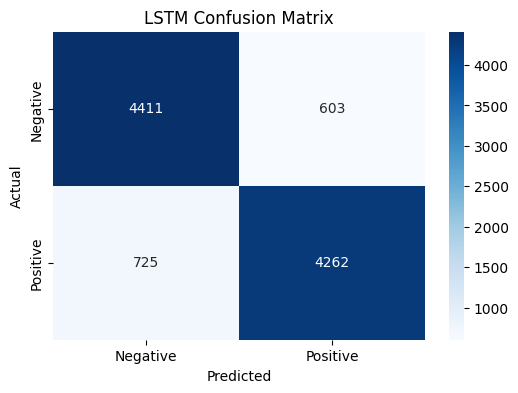

In [23]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Confusion Matrix')
plt.show()

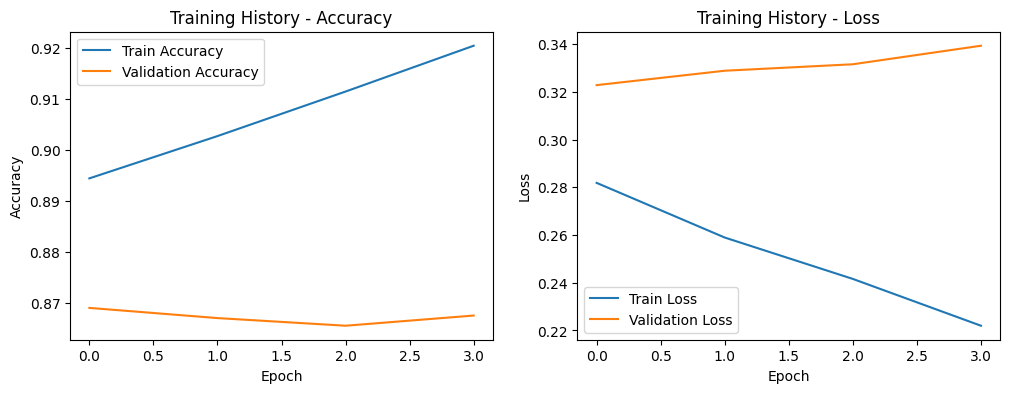

In [24]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training History - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History - Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [25]:
# Save model and tokenizer
model.save('output/lstm_sentiment_model.h5')
with open('output/lstm_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [26]:
# Demo function for LSTM
def predict_sentiment_lstm(text):
    # Load model and tokenizer
    from tensorflow.keras.models import load_model
    loaded_model = load_model('output/lstm_sentiment_model.h5')
    with open('output/lstm_tokenizer.pkl', 'rb') as f:
        loaded_tokenizer = pickle.load(f)

    # Clean and prepare text
    cleaned_text = clean_text(text)
    seq = loaded_tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

    # Predict
    proba = loaded_model.predict(padded)[0][0]
    sentiment = "Positive" if proba > 0.5 else "Negative"
    confidence = proba if proba > 0.5 else 1 - proba

    return f"{sentiment} (confidence: {confidence:.2f})"

In [27]:
# Example usage
test_text = "This movie was absolutely fantastic, I loved every minute of it!"
print(f"Text: {test_text}")
print(f"Predicted Sentiment: {predict_sentiment_lstm(test_text)}")

test_text = "The film was terrible, with bad acting and a boring plot."
print(f"Text: {test_text}")
print(f"Predicted Sentiment: {predict_sentiment_lstm(test_text)}")

Text: This movie was absolutely fantastic, I loved every minute of it!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Sentiment: Positive (confidence: 0.85)
Text: The film was terrible, with bad acting and a boring plot.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Sentiment: Negative (confidence: 0.97)
